In [1]:
'''
File trains model to detect faces. When the core application is run,
if your computer has a built-in camera, a pop-up will appear that will
immediately begin labeling faces by making model predictions every frame.
'''
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
import numpy as np
import albumentations as alb
import matplotlib.pyplot as plt
import json
import os
import time
import uuid # uniform unique identifiers - used to uniquely name images
import cv2

2023-03-09 20:36:53.285321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create and Label Data

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [9]:
# Capture images from camera
vid = cv2.VideoCapture(0) # start camera
for img_num in range(number_images):
    print(f"Collecting image {img_num}")
    ret, frame = vid.read()  # get image at frame
    image_name = os.path.join(IMAGES_PATH, f"{str(uuid.uuid1())}.jpg") # give image random name
    cv2.imwrite(image_name, frame) # save image at frame
    cv2.imshow('frame', frame) # show image
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'): # press 'q' to stop cam
        break
        
vid.release()
cv2.destroyAllWindows()

In [10]:
!labelme # opens up browser with ui to label images w/ bounding boxes

## Load Data into TF Pipeline

In [300]:
tf.data.Dataset.list_files??

In [3]:
images = tf.data.Dataset.list_files('data/images/*.jpg') # load images into Tensor object

2023-01-13 19:19:23.203658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
images

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [63]:
images.as_numpy_iterator().next()

b'data/images/21c6ab74-9226-11ed-9919-acde48001122.jpg'

In [5]:
def load_image(path):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [102]:
images = images.map(load_image) # pass in function to be applied to every image in Tensor obj

In [103]:
images.as_numpy_iterator().next().shape

(720, 1280, 3)

In [104]:
image_generator = images.batch(4).as_numpy_iterator() # get batch of 4 elements as generator

In [105]:
batch_images = image_generator.next()

In [106]:
batch_images.shape # batch of 4 images

(4, 720, 1280, 3)

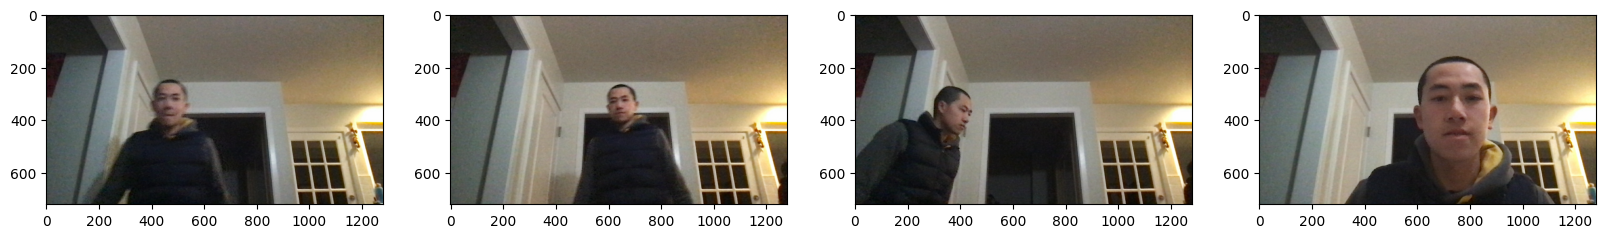

In [108]:
# Visualize images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(batch_images):
    ax[idx].imshow(image)
plt.show()

## Split Up Data - Train, Cross Validation, Test **Manually 

In [109]:
# 116 images --> 70 train, 23 val, 23 test

In [221]:
# Move matching labels to the train, val, test folders
for partition in ['train', 'val', 'test']:
    for file in os.listdir(os.path.join('data', partition, 'images')):
        
        filename = file.split('.')[0] + '.json'
        existing_label_path = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_label_path):
            new_label_path = os.path.join('data', partition, 'labels', filename)
            os.replace(existing_label_path, new_label_path)

## Apply Data Augmentation - One Image

In [6]:
# create albumentations object with settings
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450), # crop image to new size
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels'])
)

In [155]:
img = cv2.imread(os.path.join('data/train/images', 'bdc98632-9225-11ed-9919-acde48001122.jpg'))

In [157]:
with open(os.path.join('data/train/labels', 'bdc98632-9225-11ed-9919-acde48001122.json'), 'r') as f:
    label = json.load(f)

In [169]:
points = label['shapes'][0]['points']

In [170]:
points

[[595.6521739130434, 70.43478260869564],
 [885.2173913043478, 446.9565217391304]]

In [171]:
# Get coordinates of bounding box points annotation
coords = [0, 0, 0, 0]
coords[0] = points[0][0]
coords[1] = points[0][1]
coords[2] = points[1][0]
coords[3] = points[1][1]

In [174]:
coords # [x1, y1, x2, y2]

[595.6521739130434, 70.43478260869564, 885.2173913043478, 446.9565217391304]

In [175]:
# Scale coordinates to btwn 0 and 1 by dividing x-cor by width, y-cor by height -- shape=(720, 1280)
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [176]:
coords

[0.46535326086956513,
 0.09782608695652173,
 0.6915760869565217,
 0.6207729468599033]

In [216]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) # apply augmentor on selected img

In [223]:
augmented

{'image': array([[[ 20,  42,  53],
         [ 50,  69,  77],
         [132, 148, 155],
         ...,
         [ 44,  34,  34],
         [ 44,  34,  34],
         [ 44,  34,  34]],
 
        [[ 10,  32,  43],
         [ 27,  46,  54],
         [125, 138, 146],
         ...,
         [ 43,  33,  33],
         [ 43,  33,  33],
         [ 43,  33,  33]],
 
        [[  0,  22,  33],
         [ 15,  34,  42],
         [119, 135, 142],
         ...,
         [ 43,  31,  31],
         [ 40,  30,  30],
         [ 43,  31,  31]],
 
        ...,
 
        [[114, 160, 191],
         [114, 160, 191],
         [114, 160, 191],
         ...,
         [175, 180, 181],
         [175, 180, 181],
         [175, 180, 181]],
 
        [[114, 160, 191],
         [114, 160, 191],
         [114, 160, 191],
         ...,
         [176, 181, 182],
         [176, 181, 182],
         [176, 181, 182]],
 
        [[114, 160, 191],
         [114, 160, 191],
         [114, 160, 191],
         ...,
         [176, 181,

In [217]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [218]:
augmented['bboxes'][0]

(0.2995169082125605, 0.2223188405797104, 0.9429951690821258, 1.0)

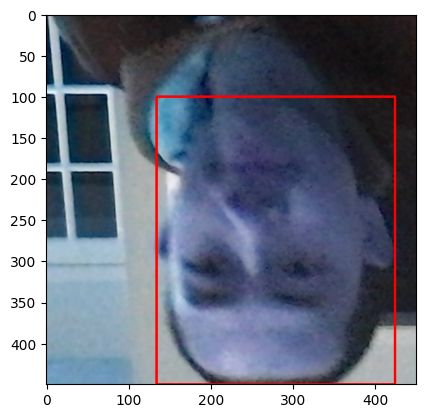

In [220]:
# Draw bounding box, scale coordinates of points for shape=(450, 450), and show image w/ random augmentation!
cv2.rectangle(
    augmented['image'],
    tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
    tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
    (255, 0, 0), 2
)

plt.imshow(augmented['image'])

## Build Augmentation Pipeline

In [230]:
# Create several augmentations on all images in each appropriate partition folder
for partition in ['train', 'val', 'test']:
    
    images_path = os.path.join('data', partition, 'images')
    labels_path = os.path.join('data', partition, 'labels')
    
    for image in os.listdir(images_path):
        
        img = cv2.imread(os.path.join(images_path, image))
        
        image_name = image.split('.')[0]
        label_path = os.path.join(labels_path, f"{image_name}.json") # path of label for this image
        
        coords = [0, 0, 0.00001, 0.00001] # init coordinates
        
        # If image has label, get coordinates and scale
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            points = label['shapes'][0]['points']
            coords[0] = points[0][0]
            coords[1] = points[0][1]
            coords[2] = points[1][0]
            coords[3] = points[1][1]
            coords = list(np.divide(coords, [1280, 720, 1280, 720])) # scale coordinates by width and height
            
        aug_images_path = os.path.join('aug_data', partition, 'images')
        aug_labels_path = os.path.join('aug_data', partition, 'labels')
        
        try:
            # Create many augmentations on one original image
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) # Apply augmentation
                # Save image in path w/ unique name
                cv2.imwrite(os.path.join(aug_images_path, f"{image_name}{x}.jpg"), augmented['image'])
                
                annotation = {} # make labels file w/ dict annotation
                annotation['image'] = image # set to filename image
                
                if os.path.exists(label_path): # if image has label
                    if len(augmented['bboxes']) == 0: # no label for this augmented img
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        # save label that the augmentor fit for us
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0
                
                # Save annotation to path of augmented labels
                with open(os.path.join(aug_labels_path, f"{image_name}{x}.json"), 'w') as f:
                    json.dump(annotation, f)
                    
        except Exception as e:
            print(e)

image must be numpy array type
y_max is less than or equal to y_min for bbox [0.4895279255319148, 0.3219562647754137, 0.7887300531914894, 0.0013297872340426035, 'face'].
x_max is less than or equal to x_min for bbox [0.9275344488188976, 0.18153980752405952, 0.7202263779527558, 0.0021872265966754153, 'face'].
y_max is less than or equal to y_min for bbox [0.6020220588235294, 0.832516339869281, 0.9898897058823529, 0.007352941176470586, 'face'].
x_max is less than or equal to x_min for bbox [0.3658088235294118, 0.23284313725490197, 0.006433823529411765, 0.97140522875817, 'face'].
x_max is less than or equal to x_min for bbox [0.6455269607843136, 0.991557734204793, 0.0037310300832662513, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.2717752659574468, 0.18306737588652489, 0.0024933510638297874, 0.9425236406619386, 'face'].
x_max is less than or equal to x_min for bbox [0.320413961038961, 0.39087301587301587, 0.0008116883116883232, 0.996933621933622, 'face'].
x_max is less t

In [7]:
# Load augmented images with tf pipeline
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x : tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x : x / 255)

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x : tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x : x / 255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x : tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x : x / 255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
train_images.as_numpy_iterator().next().shape # scaled, resized image

(120, 120, 3)

In [9]:
def load_label(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [10]:
# Load labels of augmented images with tf pipeline
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x : tf.py_function(load_label, [x], [tf.int8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x : tf.py_function(load_label, [x], [tf.int8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x : tf.py_function(load_label, [x], [tf.int8, tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=int8), array([0.548, 0.   , 1.   , 0.568], dtype=float16))

In [12]:
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(6300, 6300, 1900, 1900, 1900, 1900)

In [13]:
# Combine images with labels to finalize dataset
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(7000)
train = train.batch(8)
train = train.prefetch(4)

val   = tf.data.Dataset.zip((val_images, val_labels))
val   = val.shuffle(2000)
val   = val.batch(8)
val   = val.prefetch(4)

test  = tf.data.Dataset.zip((test_images, test_labels))
test  = test.shuffle(2000)
test  = test.batch(8)
test  = test.prefetch(4)

In [14]:
print(train.as_numpy_iterator().next()[0].shape)
print(train.as_numpy_iterator().next()[1])

(8, 120, 120, 3)
(array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]], dtype=int8), array([[0.7056 , 0.1417 , 1.     , 0.5913 ],
       [0.996  , 0.04413, 1.     , 0.5396 ],
       [0.5596 , 0.498  , 1.     , 1.     ],
       [0.686  , 0.04303, 0.9624 , 0.3647 ],
       [0.1301 , 0.0672 , 0.9644 , 1.     ],
       [0.5947 , 0.2306 , 1.     , 0.994  ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ]], dtype=float16))


In [465]:
# Load sample batch
sample = train.as_numpy_iterator()

In [466]:
res = sample.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


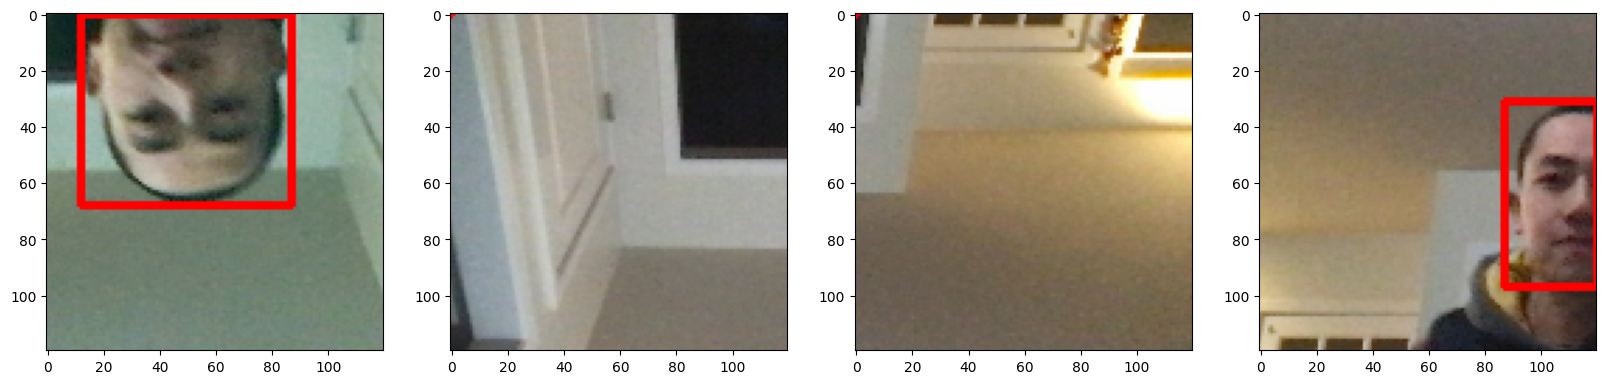

In [467]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image  = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(
        sample_image,
        tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
        tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
        (255, 0, 0), 2
    )
    
    ax[idx].imshow(sample_image)
    
plt.show()

## Build Model

In [468]:
vgg = VGG16(include_top=False)

In [469]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [470]:
# Customize model to use VGG16 and output 5 #s: class, then 2 coordinate points = 5 outputs
# class is classification, the points are regression models
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Model for classification
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) # 1 output face or no face
    
    # Model for regression
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 outputs regression btwn 0 and 1 for coordinates
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return facetracker

In [471]:
facetracker = build_model()

In [472]:
facetracker.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_10[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d_6 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [473]:
X, y = train.as_numpy_iterator().next()

In [478]:
X.shape

(8, 120, 120, 3)

In [479]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 570ms/step


In [480]:
classes, coords

(array([[0.5772472 ],
        [0.5783612 ],
        [0.6607621 ],
        [0.64491606],
        [0.64642876],
        [0.544835  ],
        [0.5659194 ],
        [0.5480446 ]], dtype=float32),
 array([[0.5866627 , 0.40416253, 0.4877068 , 0.4247479 ],
        [0.552388  , 0.38819492, 0.49926916, 0.3998334 ],
        [0.5718691 , 0.328735  , 0.4831308 , 0.36621124],
        [0.5760407 , 0.37275288, 0.39742893, 0.49857524],
        [0.5183897 , 0.32692388, 0.45272505, 0.46436423],
        [0.57488537, 0.3604003 , 0.4020392 , 0.41294655],
        [0.59089655, 0.43218482, 0.40159416, 0.43452567],
        [0.58770305, 0.36926994, 0.46087137, 0.41668484]], dtype=float32))

In [481]:
len(train)

788

In [483]:
batches_per_epoch = len(train)
lr_decay = (1 / 0.75 - 1) / batches_per_epoch # specify how learning_rate is changed

In [484]:
lr_decay

0.0004230118443316412

In [486]:
tf.keras.optimizers.legacy.Adam??

In [498]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) # set optimizer w/ specifications (decay para is deprecated)

In [499]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    w_true = y_true[:, 2] - y_true[:, 0]
    h_true = y_true[:, 3] - y_true[:, 1]
    
    w_pred = yhat[:, 2] - yhat[:, 0]
    h_pred = yhat[:, 3] - yhat[:, 1]
    
    delta_size = tf.reduce_sum(tf.square(w_pred - w_true) + tf.square(h_pred - h_true))
    
    return delta_coord + delta_size

In [500]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [501]:
regressloss(y[1], coords) # initial loss for one batch (before training)

<tf.Tensor: shape=(), dtype=float32, numpy=5.8751936>

In [502]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7379465>

## Train Model

In [515]:
# Create custom model class
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
        
    def compile(self, opt, classloss, regressloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = regressloss
        self.opt = opt
        
    # Custom training step b/c we are using 2 different losses
    def train_step(self, batch, **kwargs):
        X, y = batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True) # model's prediction
            # get both losses
            batch_classloss = self.closs(y[0], classes)
            batch_regressloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_classloss + 0.5 * batch_regressloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables) # calculate gradients of variables
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables)) # apply gradients, update variables
        
        return {'total_loss' : total_loss,
                'class_loss' : batch_classloss,
                'regress_loss' : batch_regressloss}
    
    # Get losses of validation set to track model progress - Doesn't change anything
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self.model(X, training=False) # make prediction, don't train
        
        batch_classloss = self.closs(y[0], classes)
        batch_regressloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        
        total_loss = batch_classloss + 0.5 * batch_regressloss
        
        return {'total_loss' : total_loss,
                'class_loss' : batch_classloss,
                'regress_loss' : batch_regressloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [510]:
# Custom class model
model = FaceTracker(facetracker)

In [511]:
model.compile(opt, classloss, regressloss)

In [512]:
# Set up logs before training
logdir = 'logs'

In [513]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [514]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
788/788 [==============================] - 1614s 2s/step - total_loss: 0.4394 - class_loss: 0.1585 - regress_loss: 0.5619 - val_val_total_loss: 0.0356 - val_val_class_loss: 0.0181 - val_val_regress_loss: 0.0350
Epoch 2/40
788/788 [==============================] - 1615s 2s/step - total_loss: 0.2236 - class_loss: 0.0921 - regress_loss: 0.2629 - val_val_total_loss: 0.0539 - val_val_class_loss: 0.0414 - val_val_regress_loss: 0.0250
Epoch 3/40
788/788 [==============================] - 1601s 2s/step - total_loss: 0.1953 - class_loss: 0.0819 - regress_loss: 0.2268 - val_val_total_loss: 0.1411 - val_val_class_loss: 0.0689 - val_val_regress_loss: 0.1443
Epoch 4/40
788/788 [==============================] - 1586s 2s/step - total_loss: 0.1601 - class_loss: 0.0679 - regress_loss: 0.1845 - val_val_total_loss: 0.0426 - val_val_class_loss: 0.0203 - val_val_regress_loss: 0.0448
Epoch 5/40
788/788 [==============================] - 1537s 2s/step - total_loss: 0.1549 - class_loss: 0.0635 - 

## Check Performance

In [522]:
hist.history.keys()

dict_keys(['total_loss', 'class_loss', 'regress_loss', 'val_val_total_loss', 'val_val_class_loss', 'val_val_regress_loss'])

In [537]:
hist.history

{'total_loss': [0.013597636483609676,
  0.3069740831851959,
  0.03131992369890213,
  0.07948370277881622,
  0.019277386367321014,
  0.011592685244977474,
  0.01674787327647209,
  0.018926581367850304,
  0.012721358798444271,
  0.005913357716053724,
  0.005373210646212101,
  0.05208636820316315,
  0.008366735652089119,
  0.008840605616569519,
  0.038216859102249146,
  0.04725648835301399,
  0.06766722351312637,
  0.009409796446561813,
  0.030745454132556915,
  0.0018257003976032138,
  0.0119522949680686,
  0.014102606102824211,
  0.003628012491390109,
  0.11756426841020584,
  0.0019785864278674126,
  0.014458349905908108,
  0.005923640448600054,
  0.003960584290325642,
  0.005763491149991751,
  0.008255166932940483,
  0.001245434395968914,
  0.0016636878717690706,
  0.004229160025715828,
  0.0014614928513765335,
  0.005189652554690838,
  0.004227969795465469,
  0.007079189643263817,
  0.0015756194479763508,
  0.0013637105002999306,
  0.001955778803676367],
 'class_loss': [0.007197609636

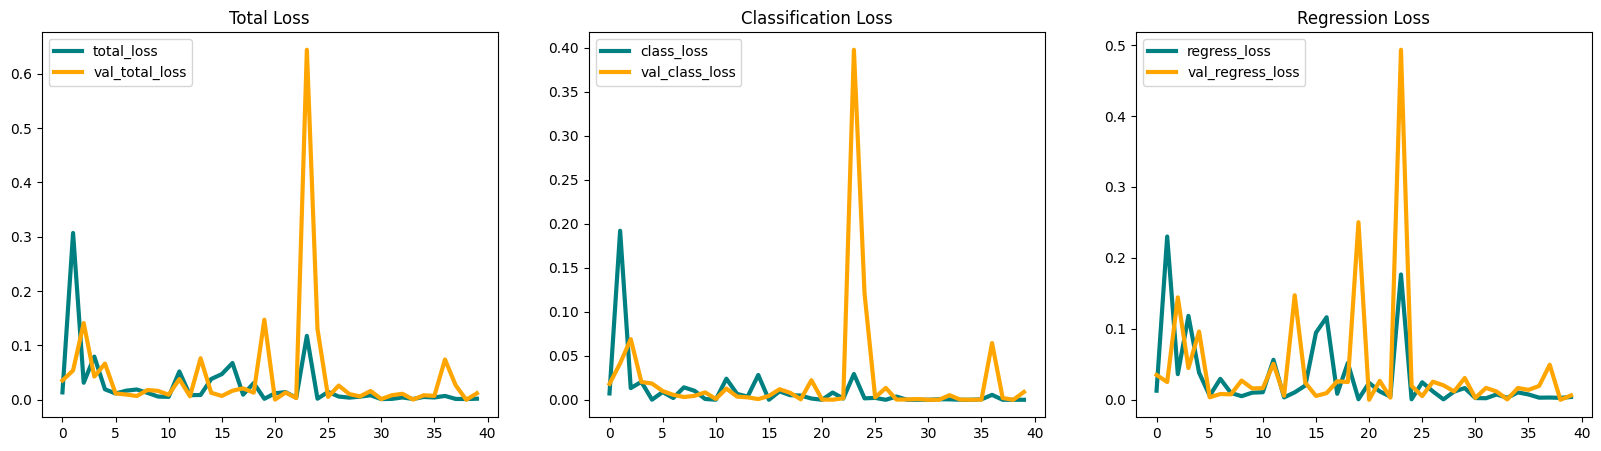

In [660]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
ax[0].plot(hist.history['total_loss'], color='teal', linewidth=3, label='total_loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', linewidth=3, label='val_total_loss')
ax[0].set_title('Total Loss')
ax[0].legend(loc='upper left')
ax[1].plot(hist.history['class_loss'], color='teal', linewidth=3, label='class_loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', linewidth=3, label='val_class_loss')
ax[1].set_title('Classification Loss')
ax[1].legend(loc='upper left')
ax[2].plot(hist.history['regress_loss'], color='teal', linewidth=3, label='regress_loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', linewidth=3, label='val_regress_loss')
ax[2].set_title('Regression Loss')
ax[2].legend(loc='upper left')

plt.show()

## Test Model

In [15]:
test_sample = test.as_numpy_iterator()

In [16]:
test_batch = test_sample.next()

In [698]:
yhat = model.predict(test_batch[0])

1/1 [==============================] - 0s 276ms/step


In [699]:
yhat[1][0]

array([2.2275670e-05, 7.6503908e-05, 3.4346194e-05, 7.2415132e-05],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/sd/tgg606r96hzdkwbm564b4vz80000gn/T/ipykernel_5831/2561137696.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


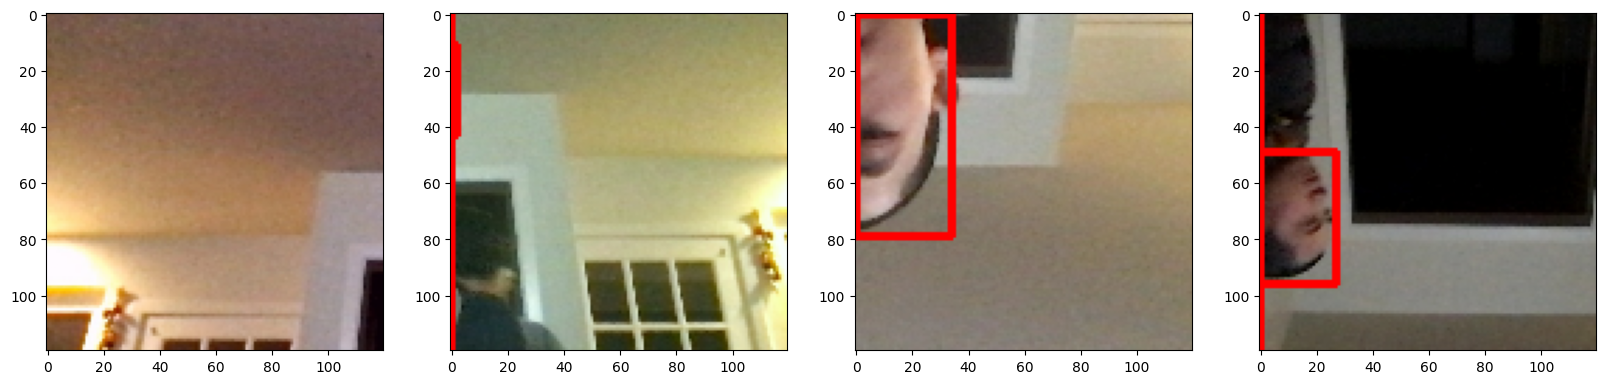

In [700]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(len(ax)):
    test_image = test_batch[0][idx] # get image
    test_coords = yhat[1][idx] # get coordinates from prediction
    
    if yhat[0][idx] >= 0.5: # if model predicts a face
        cv2.rectangle( # make box, scale coordinates
            test_image,
            tuple(np.multiply(test_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(test_coords[2:], [120, 120]).astype(int)),
            (255, 0, 0), 2
        )
    ax[idx].imshow(test_image)
fig.show()

In [668]:
facetracker.save('facetracker.h5') # save model

## Load Model

In [2]:
facetracker = load_model('facetracker.h5') # load model

2023-03-09 20:37:07.806955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test Real-Time Detection

In [3]:
vid = cv2.VideoCapture(0)
while True:
    time.sleep(0.1)
    _ , frame = vid.read() # get image at frame
    x = frame
    frame = frame[135:585, 415:865, :] # get only 450x450 pixels
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert from BGR to RGB color (opencv is BGR)
    resized = tf.image.resize(rgb, (120, 120)) # scale image to 120x120 to pass to model
    
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0)) # scale pixel values, expand to fit shape
    coords = yhat[1][0] # coordinates
    
    if yhat[0] >= 0.5: # if model predicts face
        # Need to unscale coordinates to display box
        point1_unscaled = np.multiply(coords[:2], [450, 450]).astype(int) # unscale to size 450x450
        point2_unscaled = np.multiply(coords[2:], [450, 450]).astype(int) # unscale to size 450x450
        # Face rectangle
        cv2.rectangle(
            frame,
            tuple(point1_unscaled),
            tuple(point2_unscaled),
            (255, 0, 0), 2
        )
        # Label rectangle - background of 'face' text
        cv2.rectangle(
            frame,
            tuple(np.add(point1_unscaled, [0, -30])),
            tuple(np.add(point1_unscaled, [80, 0])),
            (255, 0, 0), -1
        )
        # Label text
        cv2.putText(
            frame,
            'face',
            tuple(np.add(point1_unscaled, [0, -5])),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA
        )
    
    cv2.imshow('Eyetrack', frame) # show frame in window
    
    if cv2.waitKey(1) & 0xFF == ord('q'): # close if press 'q'
        break
vid.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 56ms/step
